Библиотека для построения embedding

In [ ]:
!pip install ampligraph

     |████████████████████████████████| 168 kB 5.4 MB/s 
     |████████████████████████████████| 6.4 MB 46.8 MB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 
     |████████████████████████████████| 2.7 MB 56.9 MB/s 
     |████████████████████████████████| 482 kB 72.4 MB/s 
     |████████████████████████████████| 120 kB 67.1 MB/s 
     |████████████████████████████████| 561 kB 64.2 MB/s 
     |████████████████████████████████| 69 kB 8.3 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 41 kB 731 kB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 100 kB 12.0 MB/s 
     |████████████████████████████████| 121 kB 62.8 MB/s 
     |████████████████████████████████| 90 kB 12.0 MB/s 
  Created wheel for commonmark: filename=CommonMark-0.5.4-py3-none-any.whl size=30768 sha256=9386787cb5595b1a05d1cf3ec165eceebc7db78ecef1c314137d5aee6a45f2a5
  Stored in directory: /root/.cache/pip/wh

импорт необходимых библиотек и пакетов

In [ ]:
import requests
import pandas as pd
import numpy as np
%tensorflow_version 1.x
from ampligraph.latent_features import ComplEx
from ampligraph.evaluation import train_test_split_no_unseen
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score



TensorFlow 1.x selected.


Считываем набор данных по результатам футбольных матчей в период с 1872 по 2019 гг.

In [ ]:
df = pd.read_csv("/content/football_results.csv").sort_values("date")
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    2
away_score    2
tournament    0
city          0
country       0
neutral       0
dtype: int64

Удаляем пустые строки из датафрейма

In [ ]:
df = df.dropna()

Разделяем выборку до 2016 и после 2016 года для обучающей и валидационной (тестовой) выборки

In [ ]:
df["train"] = df.date < "2016-01-01"
df.train.value_counts()

True     37576
False     3195
Name: train, dtype: int64

Разделяем признаки по принадлежности для будущего формирования графа знаний

In [ ]:
df["match_id"] = df.index.values.astype(str)
df["match_id"] =  "Match" + df.match_id
df["city_id"] = "City" + df.city.str.title().str.replace(" ", "")
df["country_id"] = "Country" + df.country.str.title().str.replace(" ", "")
df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
df["tournament_id"] = "Tournament" + df.tournament.str.title().str.replace(" ", "")
df["neutral"] = df.neutral.astype(str)

In [ ]:
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,train,match_id,city_id,country_id,home_team_id,away_team_id,tournament_id
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,True,Match0,CityGlasgow,CountryScotland,TeamScotland,TeamEngland,TournamentFriendly
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,True,Match1,CityLondon,CountryEngland,TeamEngland,TeamScotland,TournamentFriendly
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,True,Match2,CityGlasgow,CountryScotland,TeamScotland,TeamEngland,TournamentFriendly
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,True,Match3,CityLondon,CountryEngland,TeamEngland,TeamScotland,TournamentFriendly
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,True,Match4,CityGlasgow,CountryScotland,TeamScotland,TeamEngland,TournamentFriendly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,2019-07-10,Senegal,Benin,1.0,0.0,African Cup of Nations,Cairo,Egypt,True,False,Match40766,CityCairo,CountryEgypt,TeamSenegal,TeamBenin,TournamentAfricanCupOfNations
40767,2019-07-11,Ivory Coast,Algeria,1.0,1.0,African Cup of Nations,Suez,Egypt,True,False,Match40767,CitySuez,CountryEgypt,TeamIvoryCoast,TeamAlgeria,TournamentAfricanCupOfNations
40768,2019-07-11,Madagascar,Tunisia,0.0,3.0,African Cup of Nations,Cairo,Egypt,True,False,Match40768,CityCairo,CountryEgypt,TeamMadagascar,TeamTunisia,TournamentAfricanCupOfNations
40769,2019-07-14,Algeria,Nigeria,2.0,1.0,African Cup of Nations,Cairo,Egypt,True,False,Match40769,CityCairo,CountryEgypt,TeamAlgeria,TeamNigeria,TournamentAfricanCupOfNations


Готовим формирование нового датафрейма с предикатами (отношениями) субъектов к объектам

In [ ]:
triples = []
for _, row in df[df["train"]].iterrows():
    # сведения о домашнем или гостевом матче
    home_team = (row["home_team_id"], "isHomeTeamIn", row["match_id"])
    away_team = (row["away_team_id"], "isAwayTeamIn", row["match_id"])
    
    # Результаты матчей
    if row["home_score"] > row["away_score"]:
        score_home = (row["home_team_id"], "winnerOf", row["match_id"])
        score_away = (row["away_team_id"], "loserOf", row["match_id"])
    elif row["home_score"] < row["away_score"]:
        score_away = (row["away_team_id"], "winnerOf", row["match_id"])
        score_home = (row["home_team_id"], "loserOf", row["match_id"])
    else:
        score_home = (row["home_team_id"], "draws", row["match_id"])
        score_away = (row["away_team_id"], "draws", row["match_id"])
    home_score = (row["match_id"], "homeScores", np.clip(int(row["home_score"]), 0, 5))
    away_score = (row["match_id"], "awayScores", np.clip(int(row["away_score"]), 0, 5))
    
    # Другие признаки матчей (турнир, город, страна, нейтральная или нет, год)
    tournament = (row["match_id"], "inTournament", row["tournament_id"])
    city = (row["match_id"], "inCity", row["city_id"])
    country = (row["match_id"], "inCountry", row["country_id"])
    neutral = (row["match_id"], "isNeutral", row["neutral"])
    year = (row["match_id"], "atYear", row["date"][:4])
    
    triples.extend((home_team, away_team, score_home, score_away, 
                    tournament, city, country, neutral, year, home_score, away_score))

In [ ]:
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,train,match_id,city_id,country_id,home_team_id,away_team_id,tournament_id
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,True,Match0,CityGlasgow,CountryScotland,TeamScotland,TeamEngland,TournamentFriendly
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,True,Match1,CityLondon,CountryEngland,TeamEngland,TeamScotland,TournamentFriendly
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,True,Match2,CityGlasgow,CountryScotland,TeamScotland,TeamEngland,TournamentFriendly
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,True,Match3,CityLondon,CountryEngland,TeamEngland,TeamScotland,TournamentFriendly
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,True,Match4,CityGlasgow,CountryScotland,TeamScotland,TeamEngland,TournamentFriendly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,2019-07-10,Senegal,Benin,1.0,0.0,African Cup of Nations,Cairo,Egypt,True,False,Match40766,CityCairo,CountryEgypt,TeamSenegal,TeamBenin,TournamentAfricanCupOfNations
40767,2019-07-11,Ivory Coast,Algeria,1.0,1.0,African Cup of Nations,Suez,Egypt,True,False,Match40767,CitySuez,CountryEgypt,TeamIvoryCoast,TeamAlgeria,TournamentAfricanCupOfNations
40768,2019-07-11,Madagascar,Tunisia,0.0,3.0,African Cup of Nations,Cairo,Egypt,True,False,Match40768,CityCairo,CountryEgypt,TeamMadagascar,TeamTunisia,TournamentAfricanCupOfNations
40769,2019-07-14,Algeria,Nigeria,2.0,1.0,African Cup of Nations,Cairo,Egypt,True,False,Match40769,CityCairo,CountryEgypt,TeamAlgeria,TeamNigeria,TournamentAfricanCupOfNations


Формируем новый датафрейм по принципу: субъект - отношение (предикат) - объект

In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Match3129") | (triples_df.object=="Match3129")]

,subject,predicate,object
34419,TeamBrazil,isHomeTeamIn,Match3129
34420,TeamUruguay,isAwayTeamIn,Match3129
34421,TeamBrazil,loserOf,Match3129
34422,TeamUruguay,winnerOf,Match3129
34423,Match3129,inTournament,TournamentFifaWorldCup
34424,Match3129,inCity,CityRioDeJaneiro
34425,Match3129,inCountry,CountryBrazil
34426,Match3129,isNeutral,False
34427,Match3129,atYear,1950
34428,Match3129,homeScores,1


Визуализируем полученный граф знаний с помощью networkx

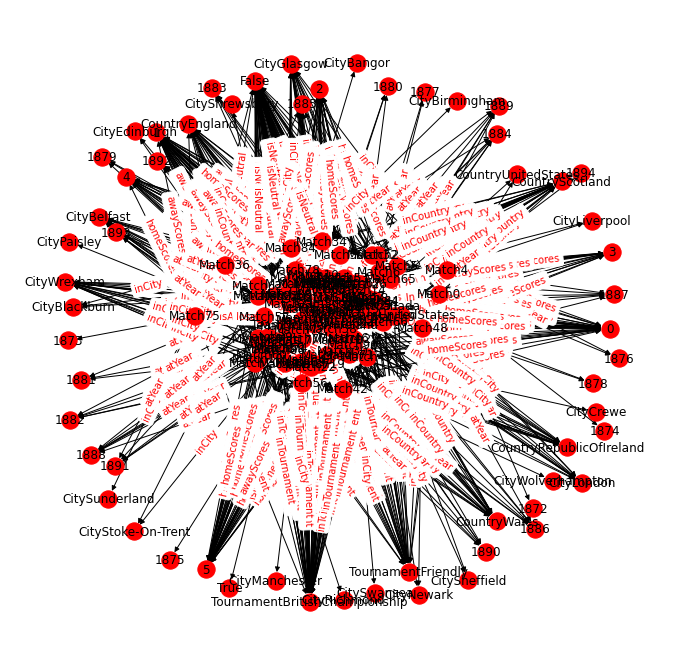

In [ ]:
import networkx as nx
from matplotlib import pyplot as plt

# create a directed-graph from a dataframe
asd = triples_df.drop(triples_df.index[1000:])

G=nx.from_pandas_edgelist(asd, "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

for index, row in asd.iterrows():
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels={(row['subject'], row['object']): row['predicate'],},
        font_color='red'
    )
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Формируем обучающую и валидационную (тестовую) выборки для обучения модели embedding

In [ ]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

Смотрим размерности выборок

In [ ]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (403336, 3)
Test set size:  (10000, 3)


Создаем экземпляр модели по ComplEx для формирования embedding

In [ ]:
model = ComplEx(batches_count=50,
                epochs=50,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)

Обучаем модель по формированию embedding с помощью ComplEx

In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train)

Average ComplEx Loss:   0.263902: 100%|██████████| 50/50 [04:10<00:00,  5.01s/epoch]


Кодируем метки для классификации

In [ ]:
df["results"] = (df.home_score > df.away_score).astype(int) + \
                (df.home_score == df.away_score).astype(int)*2 + \
                (df.home_score < df.away_score).astype(int)*3 - 1

In [ ]:
df["results"]

0        1
1        0
2        0
3        1
4        0
        ..
40766    0
40767    1
40768    2
40769    0
40770    0
Name: results, Length: 40771, dtype: int64

Готовим функции для формирования обучающей и тестовой выборок

In [ ]:
teams = pd.concat((df.home_team_id[df["train"]], df.away_team_id[df["train"]])).unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

def get_target_features(mask):
    
    def get_embeddings(team):
        return team_embeddings.get(team, np.full(200, 0))
    
    X = np.hstack((np.vstack(df[mask].home_team_id.apply(get_embeddings).values),
                   np.vstack(df[mask].away_team_id.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

Формируем обучающую и тестовую выборки

In [ ]:
clf_X_train, y_train = get_target_features((df["train"]))
clf_X_test, y_test = get_target_features((~df["train"]))

Смотрим размерности обучающей и тестовой выборок

In [ ]:
clf_X_train.shape, clf_X_test.shape

((37576, 400), (3195, 400))

Алгоритм k-ближайших соседей (K-nearest neighbours)

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(clf_X_train, y_train)

y_hat_test = model_knn.predict(clf_X_test)
accuracy = accuracy_score(y_test, y_hat_test)
print("Точность: ", accuracy)

0.5017214397496088


Алгоритм случайного леса (Random Forest Classifier)

In [ ]:
model_random_forest = RandomForestClassifier()
model_random_forest.fit(clf_X_train, y_train)

y_hat_test = model_random_forest.predict(clf_X_test)
accuracy = accuracy_score(y_test, y_hat_test)
print("Точность: ", accuracy)

0.5214397496087637


С помощью GridSearchCV подбираем оптимальные параметры для алгоритма рекомендательной системы

In [ ]:
random_forest_parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
clf_random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=random_forest_parameters, cv=5)
clf_random_forest.fit(clf_X_train, y_train)

y_hat_test_cv = clf_random_forest.predict(clf_X_test)
accuracy_cv = accuracy_score(y_test, y_hat_test_cv)
print("Наилучшие параметры Random Forest Classifier: ", clf_random_forest.best_params_)
print("Наилучшая точность: ", accuracy_cv)